Перед вами набор данных, который содержит все когда-либо выпущенные карты Magic: The Gathering. Для большего понимания, о чем идет речь, вы можете перейти на официальный сайт игры и ознакомиться с базовыми правилами.

 
На основе этих данных составьте отчет, который будет содержать следующую информацию:

 
1) Распределение карт по цвету в зависимости от редкости.

2) Процент карт, запрещенных в формате Commander, а также распределение по типу для этих карт.

3) Топ-10 карт, не являющихся землями, которые были напечатаны в наибольшем количестве сетов.

4) Для карт, не являющихся землями, определите, какая часть из них даёт ману с помощью своего эффекта. Покажите распределение по типу маны, который дают эти карты. 

# 0) Чтение и предобработка

In [1]:
#импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
df = pd.read_csv('all_mtg_cards.csv')

C:\Users\user\AppData\Local\Temp\ipykernel_16232\4211215967.py:1: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('all_mtg_cards.csv')


In [3]:
df.sample(3)

,name,multiverse_id,layout,names,mana_cost,cmc,colors,color_identity,type,supertypes,...,foreign_names,printings,original_text,original_type,legalities,source,image_url,set,set_name,id
58954,Nadir Kraken,NaN,normal,NaN,{1}{U}{U},3.0,['Blue'],['U'],Creature — Kraken,NaN,...,NaN,"['NCC', 'PRM', 'PTHB', 'THB']",NaN,NaN,"[{'format': 'Commander', 'legality': 'Legal'},...",NaN,NaN,THB,Theros Beyond Death,58d145c7-a271-5538-8286-9e1c8dc0e655
19950,Covetous Urge,473169.0,normal,NaN,{U/B}{U/B}{U/B}{U/B},4.0,"['Black', 'Blue']","['B', 'U']",Sorcery,NaN,...,"[{'name': 'Gieriges Verlangen', 'text': 'Ein G...",['ELD'],Target opponent reveals their hand. You choose...,Sorcery,"[{'format': 'Commander', 'legality': 'Legal'},...",NaN,http://gatherer.wizards.com/Handlers/Image.ash...,ELD,Throne of Eldraine,bcec5dee-375f-5367-97cc-7d8e169d4514
46842,"Eladamri, Lord of Leaves Avatar",195137.0,vanguard,NaN,NaN,0.0,NaN,NaN,Vanguard,NaN,...,NaN,['PMOA'],At the beginning of each player's precombat ma...,Vanguard,NaN,NaN,http://gatherer.wizards.com/Handlers/Image.ash...,PMOA,Magic Online Avatars,8932a905-5140-57d8-ae98-d5cd946e1432


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66770 entries, 0 to 66769
Data columns (total 39 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            66770 non-null  object 
 1   multiverse_id   47455 non-null  float64
 2   layout          66770 non-null  object 
 3   names           0 non-null      float64
 4   mana_cost       58100 non-null  object 
 5   cmc             66770 non-null  float64
 6   colors          52612 non-null  object 
 7   color_identity  59739 non-null  object 
 8   type            66770 non-null  object 
 9   supertypes      9912 non-null   object 
 10  subtypes        40903 non-null  object 
 11  rarity          66770 non-null  object 
 12  text            65805 non-null  object 
 13  flavor          34412 non-null  object 
 14  artist          66759 non-null  object 
 15  number          66770 non-null  object 
 16  power           31332 non-null  object 
 17  toughness       31332 non-null 

In [5]:
#проверим на наличие дубликатов - есть значительное количество дубликатов
df.duplicated(subset='name').sum()

42649

In [6]:
# уберем дубликаты по колонке 'name'
df = df.drop_duplicates(subset="name")

In [7]:
#в датасете есть пустые колонки, уберем их
df = df.drop(['names', 'border', 'timeshifted',\
              'reserved', 'release_date', 'starter', 'source'], axis=1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24121 entries, 0 to 66611
Data columns (total 32 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            24121 non-null  object 
 1   multiverse_id   21390 non-null  float64
 2   layout          24121 non-null  object 
 3   mana_cost       22895 non-null  object 
 4   cmc             24121 non-null  float64
 5   colors          20728 non-null  object 
 6   color_identity  21630 non-null  object 
 7   type            24121 non-null  object 
 8   supertypes      2016 non-null   object 
 9   subtypes        15107 non-null  object 
 10  rarity          24121 non-null  object 
 11  text            23780 non-null  object 
 12  flavor          14555 non-null  object 
 13  artist          24120 non-null  object 
 14  number          24121 non-null  object 
 15  power           12898 non-null  object 
 16  toughness       12898 non-null  object 
 17  loyalty         261 non-null   

в идеале необходимо заполнить все пустые значения (NaN), но, во-первых, несовсем понятно, что означает та или иная колонка, во-втрорых, нам они не пригодятся в дальнейшем

# 1) Распределение карт по цвету в зависимости от редкости.

In [9]:
#посмотрим на распределение карт по цветам
df['color_identity'].value_counts()

['B']                        3649
['W']                        3624
['R']                        3605
['U']                        3596
['G']                        3543
['B', 'R']                    335
['B', 'U']                    334
['U', 'W']                    333
['G', 'W']                    325
['G', 'R']                    324
['B', 'G']                    277
['R', 'W']                    267
['B', 'W']                    266
['R', 'U']                    255
['G', 'U']                    254
['B', 'G', 'R', 'U', 'W']      81
['B', 'R', 'U']                79
['G', 'R', 'W']                76
['B', 'G', 'R']                73
['G', 'U', 'W']                68
['B', 'U', 'W']                67
['B', 'R', 'W']                43
['B', 'G', 'U']                40
['R', 'U', 'W']                39
['G', 'R', 'U']                32
['B', 'G', 'W']                32
['G', 'R', 'U', 'W']            4
['B', 'G', 'U', 'W']            3
['B', 'R', 'U', 'W']            2
['B', 'G', 'R'

In [10]:
#возможные значения редкости
df['rarity'].unique()

array(['Uncommon', 'Common', 'Rare', 'Mythic', 'Special'], dtype=object)

некоторые карты имеют по 2 и более цвета, создадим для таких карт значения 'double', 'triple', 'quadruple',' quintuple'

In [11]:
#создадим новый датафрейм
df_1 = df[['color_identity', 'rarity']].fillna("none")

In [12]:
#заменим значения
for i in df_1.index:
    if len(df_1['color_identity'][i]) == 10:
        df_1['color_identity'][i] = 'duble'
    elif len(df_1['color_identity'][i]) == 15:
        df_1['color_identity'][i] = 'triple'
    elif len(df_1['color_identity'][i]) == 20:
        df_1['color_identity'][i] = 'quadruple'
    elif len(df_1['color_identity'][i]) == 25:
        df_1['color_identity'][i] = 'quintuple'

In [13]:
#посмотрим на распределение всех карт по цетам
df_1['color_identity'].value_counts()

['B']        3649
['W']        3624
['R']        3605
['U']        3596
['G']        3543
duble        2970
none         2491
triple        549
quintuple      81
quadruple      13
Name: color_identity, dtype: int64

In [14]:
#посмотрим на распределение всех карт по редкости
df_1['rarity'].value_counts()

Common      8415
Rare        7304
Uncommon    7151
Mythic      1246
Special        5
Name: rarity, dtype: int64

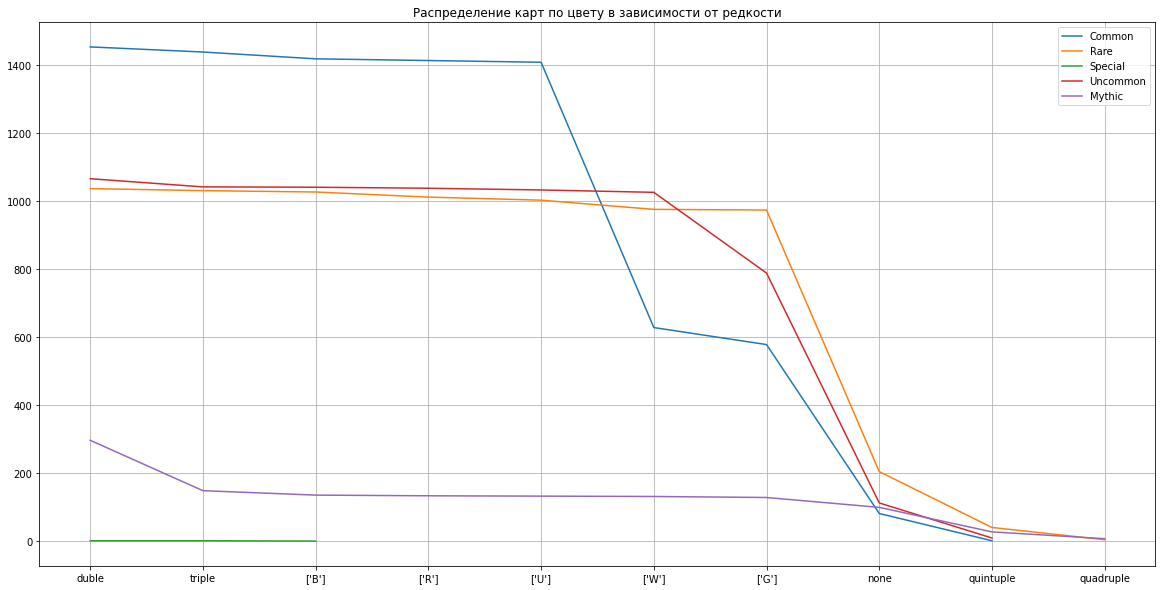

In [15]:
#построим графики
plt.figure(figsize=[20,10])  
for i in [ 'Common', 'Rare', 'Special', 'Uncommon', 'Mythic']:
    df_i = df_1[ df_1['rarity'] == i]['color_identity'].value_counts()
#     for j in df_1['color_identity'].unique():
#         if j not in df_i.index:
#             df_i[j] = 0
    df_i.plot(label = i)

plt.title("Распределение карт по цвету в зависимости от редкости")

plt.grid()
plt.legend()
plt.show()
plt.close()

На графиках можем увидеть, что
* обычных карточек зеленого и белого цвета значительно меньше, чем карт других цветов.
* Необычных карточек зеленого цвета меньше, чем других цветов.
* Количество карточек с двойным и тройным цветов несильно отличается от количества карт с одинарными цветами, но типа 'Mythic' их больше.

# 2) Процент карт, запрещенных в формате Commander, а также распределение по типу для этих карт.


In [16]:
#провери на пустые значения
df['legalities'].isnull().sum()

970

In [17]:
# создадим копию и удалим пустые значения
df_2 = df.copy()
df_2 = df_2.dropna(subset = 'legalities')

In [18]:
#проверим на запрещеннсть в формате
is_commander = []
for i in df_2['legalities']:
    list_i = ast.literal_eval(i)
    T = True
    for j in range(len(list_i)):
        if list_i[j]['format'] == 'Commander':
            is_commander.append(list_i[j]['legality'])
            T = False
    if T: is_commander.append('none')

In [19]:
df_2['is_commander'] = is_commander

In [20]:
df_2['is_commander'].value_counts()

Legal     22863
none        202
Banned       86
Name: is_commander, dtype: int64

Получаем, что 86 карты запрещены в данном формате, 22863 разрешены, а о 202 нет информации.

Можем посчитать процент.

In [21]:
pr = (df_2['is_commander'].value_counts()['Banned'] + df_2['is_commander'].value_counts()['none']) \
        /df_2['is_commander'].value_counts()['Legal'] * 100

In [22]:
print("Примерно {:.2f} % карт не используется в формате Commander".format(pr))

Примерно 1.26 % карт не используется в формате Commander


In [23]:
df_2_no_legal = df_2[(df_2['is_commander'] == 'Banned') | (df_2['is_commander'] == 'none')]

In [24]:
# Посмотрим на типы
df_2_no_legal['type'].value_counts()

Sorcery                             32
Conspiracy                          25
Instant                             25
Artifact                            16
Enchantment                          9
                                    ..
Legendary Planeswalker — Sarkhan     1
Creature — Goblin Rogue              1
Creature — Phoenix                   1
Creature — Rat                       1
Creature — Elf Archer                1
Name: type, Length: 125, dtype: int64

In [25]:
# Зманим редкие типы, на более общие (Например 'Creature — Rat' на 'Creature')
type_new = []
for i in df_2_no_legal['type']:
    type_new.append(i.split(' —')[0])
df_2_no_legal['type_new'] = type_new

In [26]:
df_2_no_legal['type_new'].value_counts()

Creature                       112
Sorcery                         32
Instant                         25
Conspiracy                      25
Legendary Creature              23
Artifact                        19
Enchantment                     18
Legendary Planeswalker          11
Artifact Creature                8
Land                             5
Legendary Artifact               4
Legendary Land                   2
Legendary Snow Creature          1
Snow Land                        1
Legendary Artifact Creature      1
Enchantment Creature             1
Name: type_new, dtype: int64

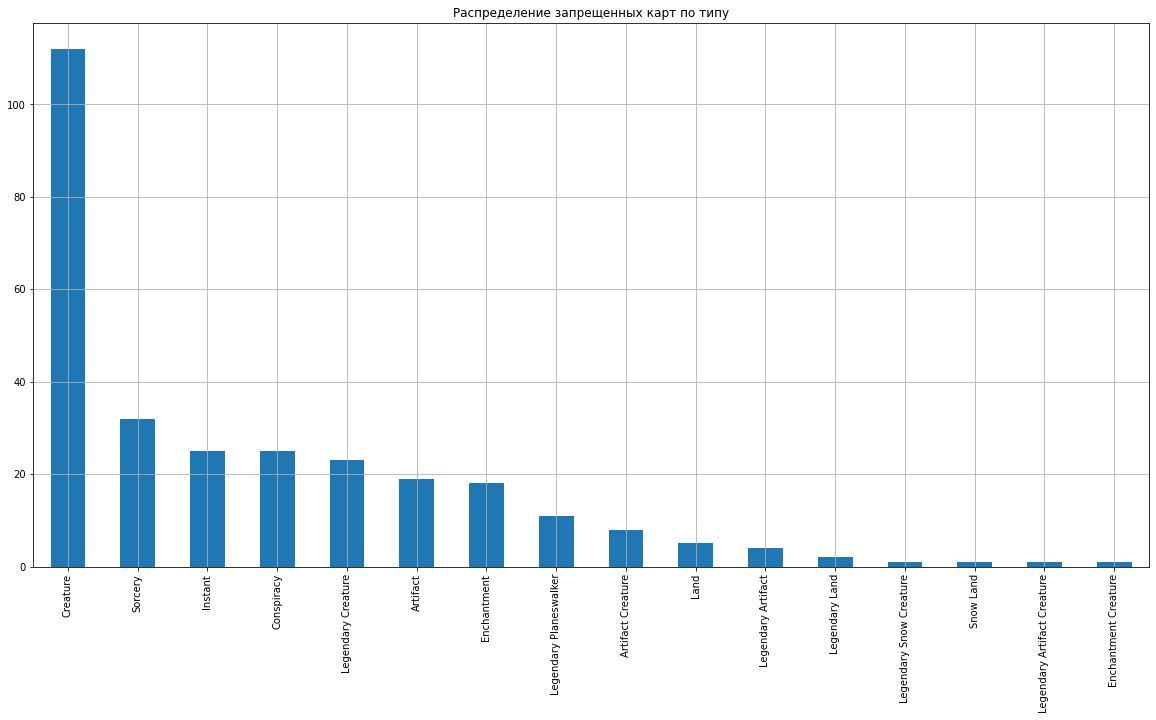

In [27]:
#построим график
plt.figure(figsize=[20,10])  

df_2_no_legal['type_new'].value_counts().plot(kind="bar")

plt.title("Распределение запрещенных карт по типу")

plt.grid()
plt.show()
plt.close()


# 3) Топ-10 карт, не являющихся землями, которые были напечатаны в наибольшем количестве сетов.


In [28]:
#создадим копию искходного датафрейма
df_3 = df.copy()
df_3.head(3)

,name,multiverse_id,layout,mana_cost,cmc,colors,color_identity,type,supertypes,subtypes,...,rulings,foreign_names,printings,original_text,original_type,legalities,image_url,set,set_name,id
0,Ancestor's Chosen,130550.0,normal,{5}{W}{W},7.0,['White'],['W'],Creature — Human Cleric,NaN,"['Human', 'Cleric']",...,NaN,"[{'name': 'Ausgewählter der Ahnfrau', 'text': ...","['10E', 'JUD', 'UMA']",First strike (This creature deals combat damag...,Creature - Human Cleric,"[{'format': 'Commander', 'legality': 'Legal'},...",http://gatherer.wizards.com/Handlers/Image.ash...,10E,Tenth Edition,5f8287b1-5bb6-5f4c-ad17-316a40d5bb0c
2,Angel of Mercy,129465.0,normal,{4}{W},5.0,['White'],['W'],Creature — Angel,NaN,['Angel'],...,NaN,"[{'name': 'Engel der Gnade', 'text': 'Fliegend...","['10E', '8ED', '9ED', 'DDC', 'DVD', 'IMA', 'IN...",Flying (This creature can't be blocked except ...,Creature - Angel,"[{'format': 'Commander', 'legality': 'Legal'},...",http://gatherer.wizards.com/Handlers/Image.ash...,10E,Tenth Edition,57aaebc1-850c-503d-9f6e-bb8d00d8bf7c
4,Angelic Blessing,129711.0,normal,{2}{W},3.0,['White'],['W'],Sorcery,NaN,NaN,...,NaN,"[{'name': 'Himmlischer Segen', 'text': 'Eine K...","['10E', '9ED', 'EXO', 'P02', 'POR', 'PS11', 'S...",Target creature gets +3/+3 and gains flying un...,Sorcery,"[{'format': 'Commander', 'legality': 'Legal'},...",http://gatherer.wizards.com/Handlers/Image.ash...,10E,Tenth Edition,55bd38ca-dc73-5c06-8f80-a6ddd2f44382


In [29]:
#проведем проверку на тип
is_land = []
for i in df_3.index:
    str_i = df_3['type'][i].split()
    is_land.append('land' in str_i or 'Land' in str_i)
df_3['is_land'] = is_land

In [30]:
#получается, что в датасете всего 810 земель 
(df_3['is_land']).value_counts()

False    23311
True       810
Name: is_land, dtype: int64

In [31]:
count_printings = []
for i in df_3[df_3['is_land'] == False]['printings']:
    count_printings.append(len(ast.literal_eval(i)))
df_3_pr_sort = pd.DataFrame(df_3[df_3['is_land'] == False]['name'])
df_3_pr_sort['count_printings'] = count_printings

In [32]:
#можем остортировать и найти первые 10
df_3_pr_sort.sort_values(by ='count_printings', ascending=False).head(10)

,name,count_printings
358,Giant Growth,47
562,Counterspell,46
53,Serra Angel,42
548,Swords to Plowshares,42
606,Dark Ritual,41
777,Sol Ring,41
526,Disenchant,41
367,Llanowar Elves,40
657,Fireball,35
93,Air Elemental,33


In [33]:
#по индексам можем получить сами карточки
index_3 = df_3_pr_sort.sort_values(by ='count_printings', ascending=False).head(10).index
df_3.loc[index_3]

,name,multiverse_id,layout,mana_cost,cmc,colors,color_identity,type,supertypes,subtypes,...,foreign_names,printings,original_text,original_type,legalities,image_url,set,set_name,id,is_land
358,Giant Growth,129568.0,normal,{G},1.0,['Green'],['G'],Instant,NaN,NaN,...,"[{'name': 'Riesenwuchs', 'text': 'Eine Kreatur...","['10E', '2ED', '3ED', '4BB', '4ED', '5ED', '6E...",Target creature gets +3/+3 until end of turn.,Instant,"[{'format': 'Commander', 'legality': 'Legal'},...",http://gatherer.wizards.com/Handlers/Image.ash...,10E,Tenth Edition,d15347ac-1e85-5d2a-9979-eef3f15c7376,False
562,Counterspell,699.0,normal,{U}{U},2.0,['Blue'],['U'],Instant,NaN,NaN,...,NaN,"['2ED', '3ED', '4BB', '4ED', '5ED', '6ED', '7E...",Counters target spell as it is being cast.,Interrupt,"[{'format': 'Commander', 'legality': 'Legal'},...",http://gatherer.wizards.com/Handlers/Image.ash...,2ED,Unlimited Edition,3e5f449f-1b20-53e9-a562-b0bc2cd46fc0,False
53,Serra Angel,129726.0,normal,{3}{W}{W},5.0,['White'],['W'],Creature — Angel,NaN,['Angel'],...,"[{'name': 'Serra-Engel', 'text': 'Fliegend, Wa...","['10E', '2ED', '3ED', '4BB', '4ED', '7ED', '8E...","Flying, vigilance (This creature can't be bloc...",Creature - Angel,"[{'format': 'Alchemy', 'legality': 'Legal'}, {...",http://gatherer.wizards.com/Handlers/Image.ash...,10E,Tenth Edition,be665b02-1cf2-50c6-8861-85da921bc853,False
548,Swords to Plowshares,869.0,normal,{W},1.0,['White'],['W'],Instant,NaN,NaN,...,NaN,"['2ED', '3ED', '4BB', '4ED', 'A25', 'AFC', 'AT...",Target creature is removed from game entirely;...,Instant,"[{'format': 'Commander', 'legality': 'Legal'},...",http://gatherer.wizards.com/Handlers/Image.ash...,2ED,Unlimited Edition,a42271e0-2a27-5cc3-973e-4e8374e72c45,False
606,Dark Ritual,651.0,normal,{B},1.0,['Black'],['B'],Instant,NaN,NaN,...,NaN,"['2ED', '3ED', '4BB', '4ED', '5ED', 'A25', 'BR...",Add 3 black mana to your mana pool.,Interrupt,"[{'format': 'Commander', 'legality': 'Legal'},...",http://gatherer.wizards.com/Handlers/Image.ash...,2ED,Unlimited Edition,b93edb62-9114-5499-8f84-b15dbe30c9d5,False
777,Sol Ring,637.0,normal,{1},1.0,NaN,NaN,Artifact,NaN,NaN,...,NaN,"['2ED', '3ED', 'AFC', 'C13', 'C14', 'C15', 'C1...",Add 2 colorless mana to your mana pool. Tappin...,Mono Artifact,"[{'format': 'Commander', 'legality': 'Legal'},...",http://gatherer.wizards.com/Handlers/Image.ash...,2ED,Unlimited Edition,fe19ba78-b922-5ce5-8ad9-276a3cfabf57,False
526,Disenchant,847.0,normal,{1}{W},2.0,['White'],['W'],Instant,NaN,NaN,...,NaN,"['2ED', '3ED', '4BB', '4ED', '5ED', '6ED', '7E...",Target enchantment or artifact must be discarded.,Instant,"[{'format': 'Alchemy', 'legality': 'Legal'}, {...",http://gatherer.wizards.com/Handlers/Image.ash...,2ED,Unlimited Edition,f0262a52-2284-5905-899c-096a32db85d0,False
367,Llanowar Elves,129626.0,normal,{G},1.0,['Green'],['G'],Creature — Elf Druid,NaN,"['Elf', 'Druid']",...,"[{'name': 'Llanowarelfen', 'text': '{T}: Erhöh...","['10E', '2ED', '3ED', '4BB', '4ED', '5ED', '6E...",{T}: Add {G} to your mana pool.,Creature - Elf Druid,"[{'format': 'Commander', 'legality': 'Legal'},...",http://gatherer.wizards.com/Handlers/Image.ash...,10E,Tenth Edition,51106f17-5dd1-5853-b45b-453d83b9d979,False
657,Fireball,794.0,normal,{X}{R},1.0,['Red'],['R'],Sorcery,NaN,NaN,...,NaN,"['2ED', '3ED', '4BB', '4ED', '5ED', 'ARC', 'AT...","Fireball does X damage total, divided evenly (...",Sorcery,"[{'format': 'Commander', 'legality': 'Legal'},...",http://gatherer.wizards.com/Handlers/Image.ash...,2ED,Unlimited Edition,8c01fc19-85e5-55b8-b149-745bf01f695f,False
93,Air Elemental,129459.0,normal,{3}{U}{U},5.0,['Blue'],['U'],Creature — Elemental,NaN,['Elemental'],...,"[{'name': 'Luftelementar', 'text': 'Fliegend (...","['10E', '2ED', '3ED', '4BB', '4ED', '5ED', '6E...",Flying (This creature can't be blocked except ...,Creature - Elemental,"[{'format': 'Alchemy', 'legality': 'Legal'}, {...",http://gatherer.wizards.com/Handlers/Image.ash...,10E,Tenth Edition,76ddd7f5-1a84-55d5-98f5-4883c217e0d8,


# 4) Для карт, не являющихся землями, определите, какая часть из них даёт ману с помощью своего эффекта. Покажите распределение по типу маны, который дают эти карты.

In [34]:
#сделаем копию прошого датафрейма без земель
df_4 = df_3[df_3['is_land'] == False].copy()

In [41]:
df_4

,name,multiverse_id,layout,mana_cost,cmc,colors,color_identity,type,supertypes,subtypes,...,foreign_names,printings,original_text,original_type,legalities,image_url,set,set_name,id,is_land
0,Ancestor's Chosen,130550.0,normal,{5}{W}{W},7.0,['White'],['W'],Creature — Human Cleric,NaN,"['Human', 'Cleric']",...,"[{'name': 'Ausgewählter der Ahnfrau', 'text': ...","['10E', 'JUD', 'UMA']",First strike (This creature deals combat damag...,Creature - Human Cleric,"[{'format': 'Commander', 'legality': 'Legal'},...",http://gatherer.wizards.com/Handlers/Image.ash...,10E,Tenth Edition,5f8287b1-5bb6-5f4c-ad17-316a40d5bb0c,False
2,Angel of Mercy,129465.0,normal,{4}{W},5.0,['White'],['W'],Creature — Angel,NaN,['Angel'],...,"[{'name': 'Engel der Gnade', 'text': 'Fliegend...","['10E', '8ED', '9ED', 'DDC', 'DVD', 'IMA', 'IN...",Flying (This creature can't be blocked except ...,Creature - Angel,"[{'format': 'Commander', 'legality': 'Legal'},...",http://gatherer.wizards.com/Handlers/Image.ash...,10E,Tenth Edition,57aaebc1-850c-503d-9f6e-bb8d00d8bf7c,False
4,Angelic Blessing,129711.0,normal,{2}{W},3.0,['White'],['W'],Sorcery,NaN,NaN,...,"[{'name': 'Himmlischer Segen', 'text': 'Eine K...","['10E', '9ED', 'EXO', 'P02', 'POR', 'PS11', 'S...",Target creature gets +3/+3 and gains flying un...,Sorcery,"[{'format': 'Commander', 'legality': 'Legal'},...",http://gatherer.wizards.com/Handlers/Image.ash...,10E,Tenth Edition,55bd38ca-dc73-5c06-8f80-a6ddd2f44382,False
6,Angelic Chorus,129710.0,normal,{3}{W}{W},5.0,['White'],['W'],Enchantment,NaN,NaN,...,"[{'name': 'Choral der Engel', 'text': 'Immer w...","['10E', 'BBD', 'USG']",Whenever a creature comes into play under your...,Enchantment,"[{'format': 'Commander', 'legality': 'Legal'},...",http://gatherer.wizards.com/Handlers/Image.ash...,10E,Tenth Edition,3b77bb52-4181-57f5-b3cd-f3a15b95aa29,False
7,Angelic Wall,129671.0,normal,{1}{W},2.0,['White'],['W'],Creature — Wall,NaN,['Wall'],...,"[{'name': 'Mauer der Engel', 'text': 'Verteidi...","['10E', 'AVR', 'M14', 'ODY', 'P02']","Defender, flying (This creature can't attack, ...",Creature - Wall,"[{'format': 'Commander', 'legality': 'Legal'},...",http://gatherer.wizards.com/Handlers/Image.ash...,10E,Tenth Edition,fadda48c-6226-5ac5-a2b9-e9170d2017cd,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66604,Sea Gate Colossus,491902.0,normal,{7},7.0,NaN,NaN,Artifact Creature — Golem Warrior,NaN,"['Golem', 'Warrior']",...,"[{'name': 'Seetor-Koloss', 'text': 'Dieser Zau...",['ZNR'],This spell costs {1} less to cast for each cre...,Artifact Creature — Golem Warrior,"[{'format': 'Alchemy', 'legality': 'Legal'}, {...",http://gatherer.wizards.com/Handlers/Image.ash...,ZNR,Zendikar Rising,75d703db-274d-5239-82a6-fba47a3fa69f,False
66606,Skyclave Sentinel,491904.0,normal,{3},3.0,NaN,NaN,Artifact Creature — Gargoyle,NaN,['Gargoyle'],...,"[{'name': 'Wächter der Himmelsfestung', 'text'...",['ZNR'],Kicker {4} (You may pay an additional {4} as y...,Artifact Creature — Gargoyle,"[{'format': 'Alchemy', 'legality': 'Legal'}, {...",http://gatherer.wizards.com/Handlers/Image.ash...,ZNR,Zendikar Rising,c80ad8a0-aaf0-5d4d-8579-a94c7f5f20af,False
66607,Spare Supplies,491905.0,normal,{2},2.0,NaN,NaN,Artifact,NaN,NaN,...,"[{'name': 'Ersatzvorräte', 'text': 'Die Ersatz...",['ZNR'],Spare Supplies enters the battlefield tapped.\...,Artifact,"[{'format': 'Alchemy', 'legality': 'Legal'}, {...",http://gatherer.wizards.com/Handlers/Image.ash...,ZNR,Zendikar Rising,e51c3a28-5719-5f1f-856a-ccdadf9411e5,False
66608,Stonework Packbeast,491906.0,normal,{2},2.0,NaN,NaN,Artifact Creature — Beast,NaN,['Beast'],...,"[{'name': 'Mauerwerk-Packbestie', 'text': 'Die...",['ZNR'],"Stonework Packbeast is also a Cleric, Rogue, W...",Artifact Creature — Beast,"[{'format': 'Alchemy', 'legality': 'Legal'}, {...",http://gatherer.wizards.com/Handlers/Image.ash...,ZNR,Zendikar Rising,51c154c6-a67b-56bb-9713-c2b10b936e4f,False


In [42]:
count_mana = 0
for i in df_4['original_text'].index:
    str_i = str(df_4['original_text'][i]).replace('{T}', '') 
    if ('Add ' in str_i or 'add ' in str_i or 'adds ' in str_i) and ('mana' in str_i or '{' in str_i):
#         print(i)
        count_mana += 1
#         print(str_i)
#         print()

Посмотрим на текст карт

Возможны такие варианты по добавлению маны в тексте

* adds one
* add one
* add two
* add 3
* add {G} и другие
* add {G}{R} и другие
* add {1}
* add {C}
* add {X}

Как я понимаю, {C} - означает любой цвет.

карты, которые дают 2 маны или больше будум относить к категории 'Any'.

Введем распределение по типу маны. Будут следующие категории - 'Any', 'Red', 'Green', 'Black', 'Blue', 'White'

In [43]:
print(count_mana, ' карт, не являющихся землями, дают ману с помощью своего эффекта')

797  карт, не являющихся землями, дают ману с помощью своего эффекта


In [44]:
mana = {'Any': 0, 'Red': 0, 'Green': 0, 'Black': 0, 'Blue': 0, 'White': 0} 
for i in df_4['original_text'].index:
    str_i = str(df_4['original_text'][i]).replace('{T}', '') 
   
    if ('Add ' in str_i or 'add ' in str_i or 'adds ' in str_i) and ('mana' in str_i or '{' in str_i):
#         print(i)
#         print(str_i)
        if '{R}' in str_i and '{G}' not in str_i and '{U}' not in str_i and '{B}' not in str_i and '{W}' not in str_i:
            mana['Red'] +=1
        elif '{R}' not in str_i and '{G}' in str_i and '{U}' not in str_i and '{B}' not in str_i and '{W}' not in str_i:
            mana['Green'] += 1
        elif '{R}' not in str_i and '{G}' not in str_i and '{U}' in str_i and '{B}' not in str_i and '{W}' not in str_i:
            mana['Black'] += 1
        elif '{R}' not in str_i and '{G}'  not in str_i and '{U}' not in str_i and '{B}' in str_i and '{W}' not in str_i:
            mana['Blue'] += 1
        elif '{R}' not in str_i and '{G}' not in str_i and '{U}' not in str_i and '{B}' not in str_i and '{W}' in str_i:
            mana['White'] += 1
        else: mana['Any'] += 1
#         print(mana)

In [45]:
mana

{'Any': 582, 'Red': 64, 'Green': 86, 'Black': 19, 'Blue': 32, 'White': 14}

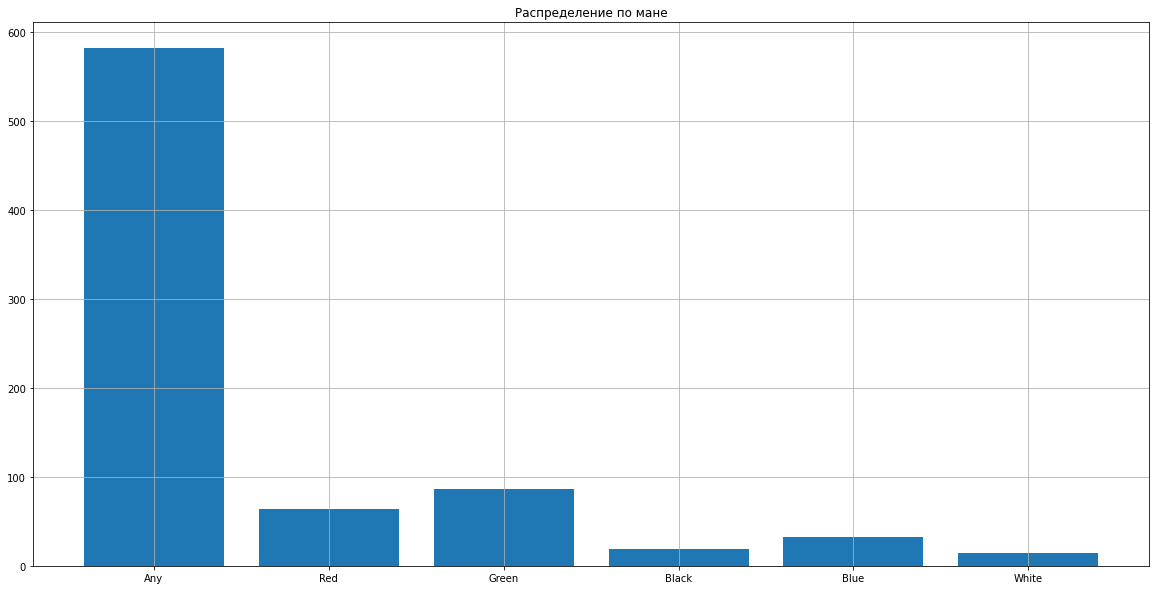

In [46]:
#построим график
plt.figure(figsize=[20,10])  

names = list(mana.keys())
values = list(mana.values())

plt.bar(range(len(mana)), values, tick_label=names)

plt.title("Распределение по мане")

plt.grid()
plt.show()
plt.close()